##**Make sure selected runtime is GPU**

##**Installing required packages**

In [10]:
%%capture
!pip install -qq super_gradients==3.5
!pip install imutils
!pip install pytube --upgrade

##**Importing the required packages**

In [11]:
import os
import cv2 as cv
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [12]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [13]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [14]:
from super_gradients.training import models

##**Initialized trainer for model fine-tuning**

In [15]:
dir_checkpoint = 'checkpoints'
trainer = Trainer(experiment_name='thermal_camera_yolonas_m', ckpt_root_dir=dir_checkpoint)

##**Upload and unzip the dataset**

Upload the compressed dataset `yolov7-aauRainSnow-dataset.zip` into `Files`

In [16]:
!unzip -q yolov7-aauRainSnow-dataset.zip
!ls
sleep(1)

sample_data  yolov7-aauRainSnow-dataset  yolov7-aauRainSnow-dataset.zip


##**Initialize the dataset parameters dictionay**



In [17]:
dataset_params = {
    'data_dir':'./yolov7-aauRainSnow-dataset',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck']
}

##**Create datasets for train, validation and test**

In [18]:
data_train = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

data_val = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

data_test = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 300/300 [00:00<00:00, 4725.98it/s]


##**Defined dataset attributes**

In [19]:
data_train.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [20]:
data_train.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

By changing values in the above dictionary, augmentation attributes can be changed.

##**A batch of training data which has data augmentation**

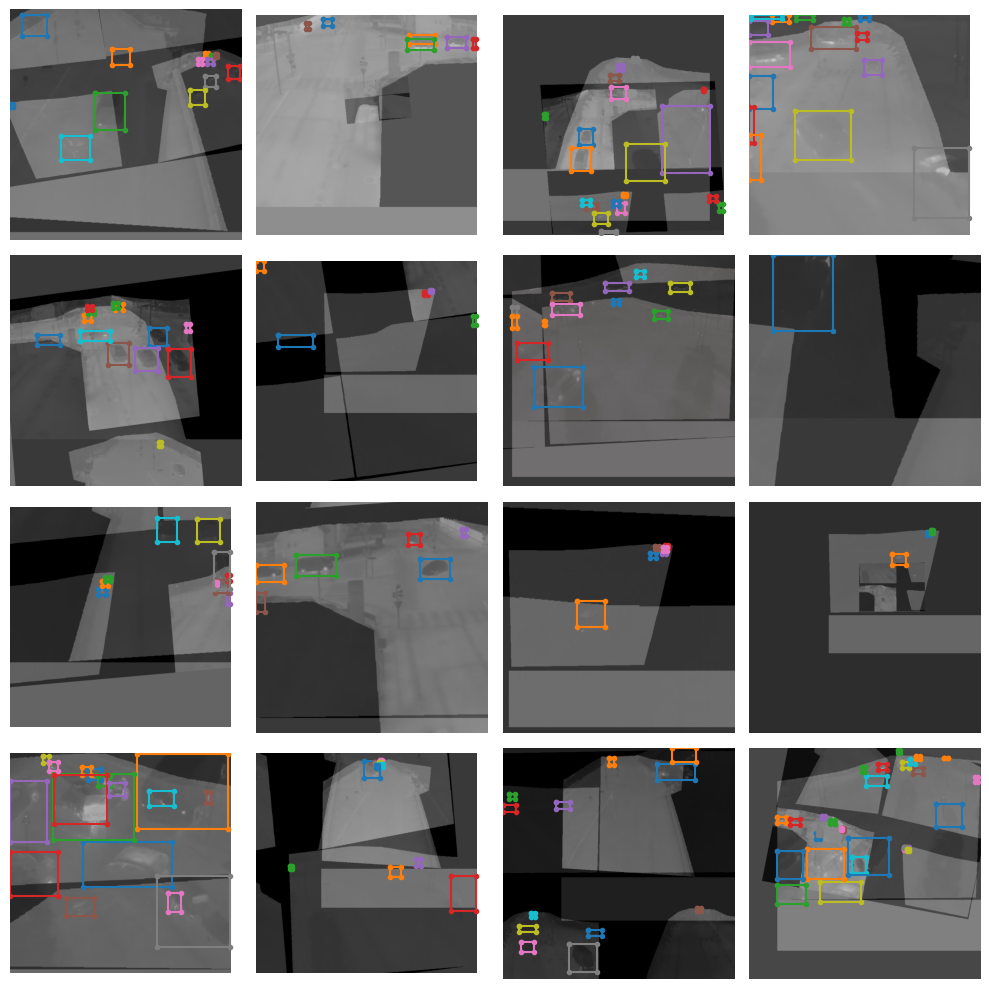

In [21]:
data_train.dataset.plot()

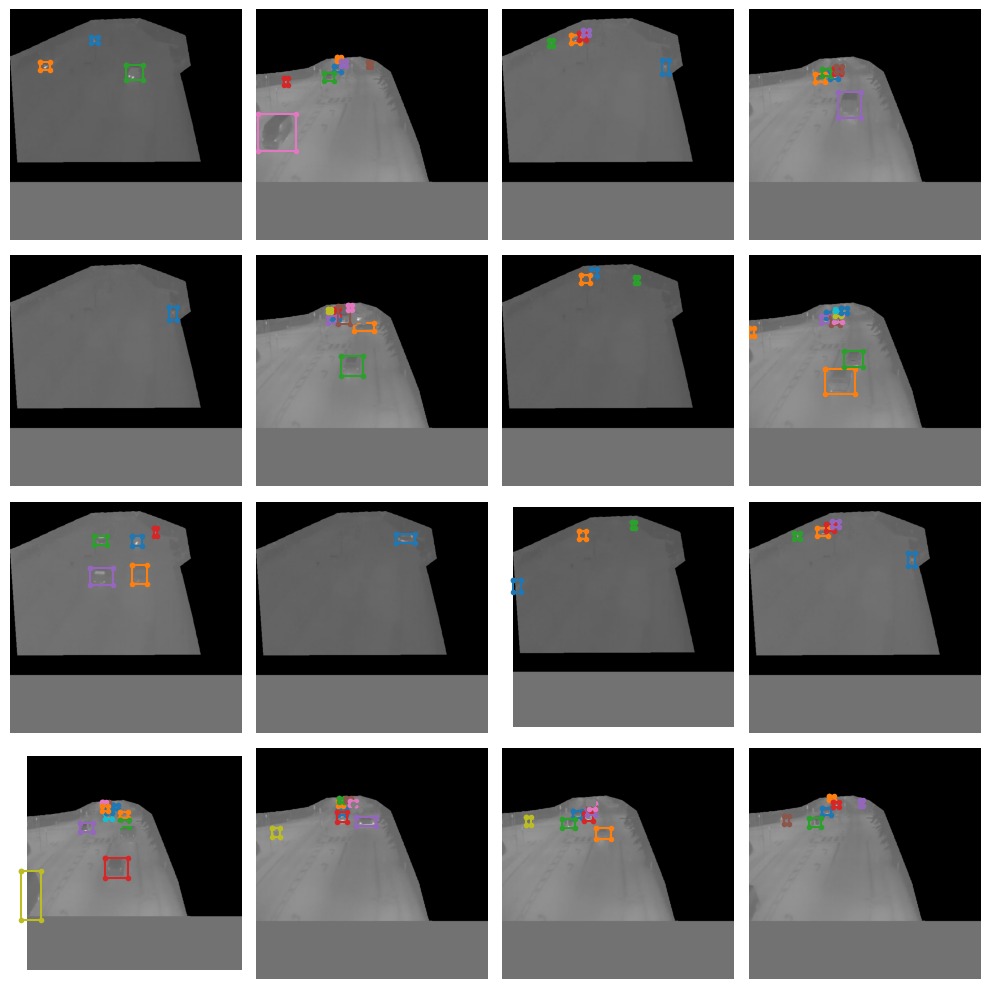

In [22]:
data_val.dataset.plot()

##**Create an instance of YOLO-NAS**

In [23]:
model_name_version = 'yolo_nas_m'

model = models.get(
            model_name_version,
            num_classes=len(dataset_params['classes']),
            pretrained_weights="coco"
          )

[2024-01-04 04:33:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:14<00:00, 14.2MB/s]
[2024-01-04 04:33:20] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


##**Setting hyper parameters and evaluation metrics**


List of all available settings that can be set for training are [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).

However, the following are required:
- `max_epochs` - maximum number of training epochs
- `loss` - the loss function
- `optimizer` - optimizer like Adam
- `train_metrics_list` - Metrics to log during training
- `valid_metrics_list` - Metrics to log during validation
- `metric_to_watch` - metric which the model checkpoint will be saved according to it



In [24]:
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

##**Training/Fine-tuning**

In [25]:
trainer.train(
      model=model,
      training_params=train_params,
      train_loader=data_train,
      valid_loader=data_val
    )

[2024-01-04 04:33:20] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240104_043320_341040`
[2024-01-04 04:33:20] INFO - sg_trainer.py - Checkpoints directory: checkpoints/thermal_camera_yolonas_m/RUN_20240104_043320_341040
[2024-01-04 04:33:20] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefix

The console stream is now moved to checkpoints/thermal_camera_yolonas_m/RUN_20240104_043320_341040/console_Jan04_04_33_20.txt


[2024-01-04 04:33:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1508       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         94         (len(train_loader))
    - Gradient updates per epoch:   94         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_M  (51.13M parameters, 51.13M optimized)
    - Learning Rates and Weight Decays:
      - default: (51.13M parameters). LR: 0.0005 (51.13M parameters) WD: 0.0, (72.22K parameters), WD: 0.0001, (51.06M parameters)

[2024-01-04 04:34:15] INFO - base_sg_logger.py - Checkpoint saved i

##**Test performace on the best trained model**

In [29]:
run_name = 'RUN_20240104_043320_341040'
path_of_best_model = './checkpoints/thermal_camera_yolonas_m/{}/ckpt_best.pth'.format(run_name)

In [30]:
best_model = models.get(
        model_name_version,
        num_classes=len(dataset_params['classes']),
        checkpoint_path=path_of_best_model
      )

In [31]:
trainer.test(
    model=best_model,
    test_loader=data_test,
    test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                              top_k_predictions=300,
                                              num_cls=len(dataset_params['classes']),
                                              normalize_targets=True,
                                              post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                        nms_top_k=1000,
                                                                                                        max_predictions=300,
                                                                                                        nms_threshold=0.7)
                                              ))

Testing:  95%|█████████▍| 18/19 [00:06<00:00,  3.09it/s]

{'PPYoloELoss/loss_cls': 0.7291842,
 'PPYoloELoss/loss_iou': 0.5484567,
 'PPYoloELoss/loss_dfl': 0.4557519,
 'PPYoloELoss/loss': 1.733393,
 'Precision@0.50': 0.047920819371938705,
 'Recall@0.50': 0.7035228610038757,
 'mAP@0.50': 0.3924815356731415,
 'F1@0.50': 0.08696390688419342}

Testing: 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]


##**Example output of the best model on one image**



[2024-01-04 05:03:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


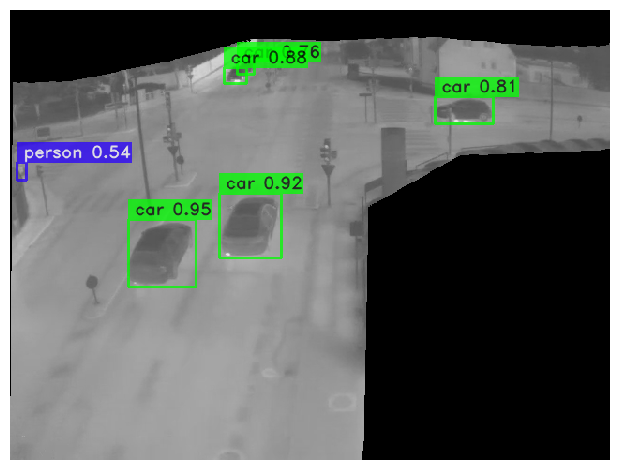

/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


In [32]:
img_path = './yolov7-aauRainSnow-dataset/train/images/570.png'
best_model.predict(img_path).show()

Predicting Images:   0%|          | 0/4 [00:00<?, ?it/s][2024-01-04 05:19:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


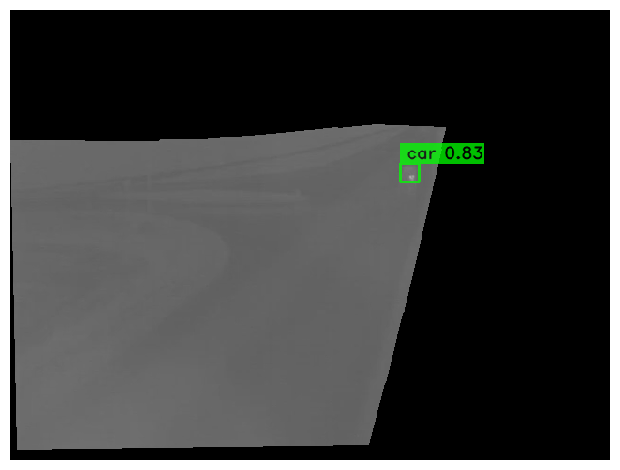

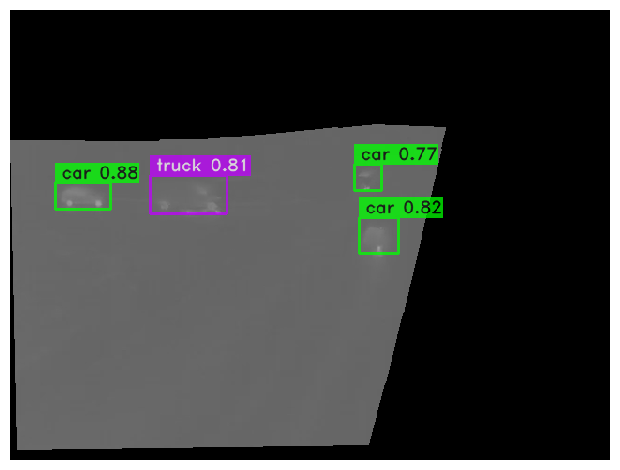

Predicting Images: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


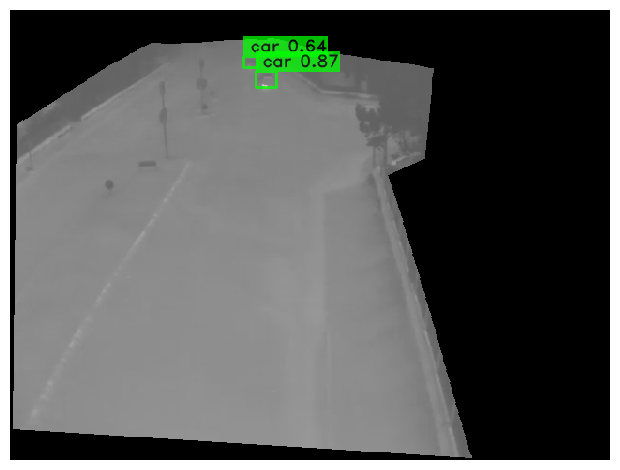

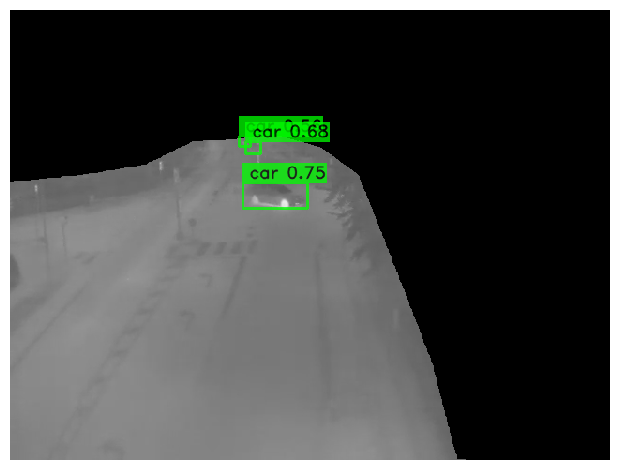

In [51]:
imgs_paths = ['./yolov7-aauRainSnow-dataset/train/images/{}.png'.format(i) for i in [20, 130, 2090, 1695]]
best_model.predict(imgs_paths).show()

##**Copy the best model in Google Drive**



In [38]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

In [42]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Specify the file paths
colab_file_path = './checkpoints/thermal_camera_yolonas_m/{}/ckpt_best.pth'.format(run_name)
drive_folder_path = '/content/drive/MyDrive'  # Replace with your actual Google Drive folder path

# Copy the file from Colab to Google Drive
!cp "{colab_file_path}" "{drive_folder_path}/"